# Title

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shelve

from lifelines import KaplanMeierFitter

from utils import decorate
from utils import values
from utils import resample_rows_weighted
from utils import round_into_bins

from empiricaldist import Pmf, Cdf

import marriage

random_seed = 12

In [2]:
def set_palette(*args, **kwds):
    """Set the matplotlib color cycler.
    
    args, kwds: same as for sns.color_palette
    
    Also takes a boolean kwd, `reverse`, to indicate
    whether the order of the palette should be reversed.
    
    returns: list of colors
    """
    reverse = kwds.pop('reverse', False)
    palette = sns.color_palette(*args, **kwds)
    
    palette = list(palette)
    if reverse:
        palette.reverse()
        
    cycler = plt.cycler(color=palette)
    plt.gca().set_prop_cycle(cycler)
    return palette

In [3]:
def plot_kmf_map(kmf_map, cohorts, **options):
    fig, ax = plt.subplots()
    palette = set_palette('hls', len(cohorts))
    for cohort in cohorts:
        series = kmf_map[cohort]
        series.plot(ax=ax, label=f'{cohort+1900}s')

    decorate(xlabel='Age (years)',
             ylabel='Percent ever married',
             xlim=[13, 55], 
             **options,
             )
    
    ax.legend(title='Decade of birth', loc='lower right')

## NSFG original analysis

Get the curves computed in marriage.ipynb

In [4]:
with shelve.open('sf_map') as d:
    sf_map = d['sf_map']

In [5]:
def PlotSurvivalFunctions(sf_map):
    """Plot estimated survival functions.

    sf_map: map from group name to sequence of survival functions
    predict_flag: whether the lines are predicted or actual
    colormap: map from group name to color
    """
    for name, sf_seq in sorted(sf_map.items(), reverse=True):
        if len(sf_seq) == 0:
            continue

        sf = sf_seq[0]
        if len(sf) == 0:
            continue

        ts, rows = marriage.MakeSurvivalCI(sf_seq, [50])
        plt.plot(ts, 100-rows[0], label='19%ds'%name, alpha=0.8)

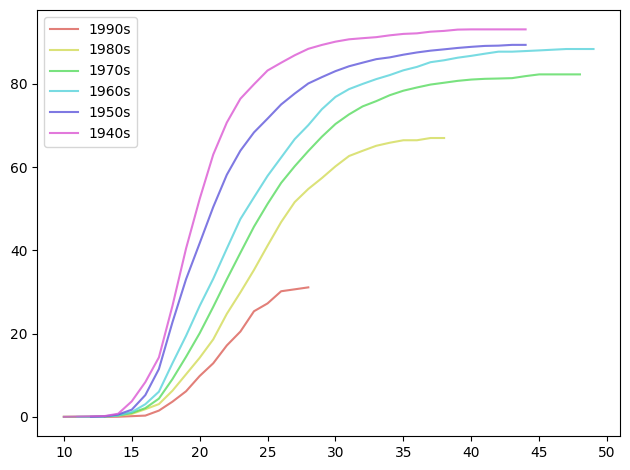

In [6]:
import marriage 

palette = set_palette('hls', 6)
PlotSurvivalFunctions(sf_map)
decorate()

## NSFG corrected analysis

Load the data cleaned in clean_nsfg.ipynb and run the analysis with lifelines

In [7]:
%time unweighted = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
unweighted.shape

CPU times: user 53.9 ms, sys: 13.3 ms, total: 67.2 ms
Wall time: 1.16 s


(70183, 45)

In [8]:
dfs = []

np.random.seed(random_seed)
for name, group in unweighted.groupby('cycle'):
    df = resample_rows_weighted(group, 'finalwgt')
    dfs.append(df)
    
nsfg_female = pd.concat(dfs).reset_index(drop=True)

In [9]:
evrmarry = nsfg_female['evrmarry']
values(evrmarry)

evrmarry
False    30192
True     39991
Name: count, dtype: int64

In [10]:
invalid = (evrmarry & nsfg_female['agemarry'].isna()).sum()

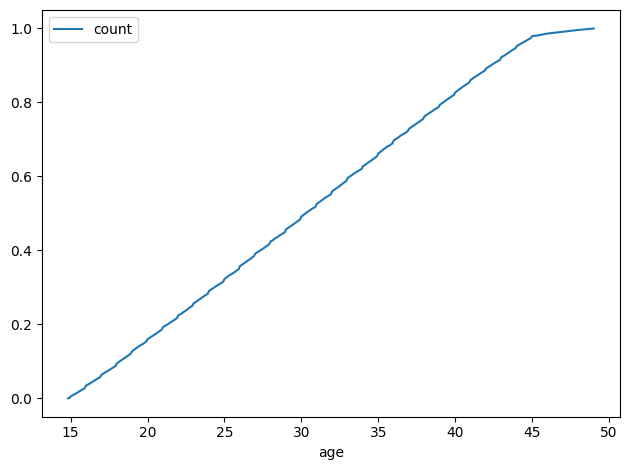

In [11]:
cdf = Cdf.from_seq(nsfg_female['age'])
cdf.plot()
decorate()

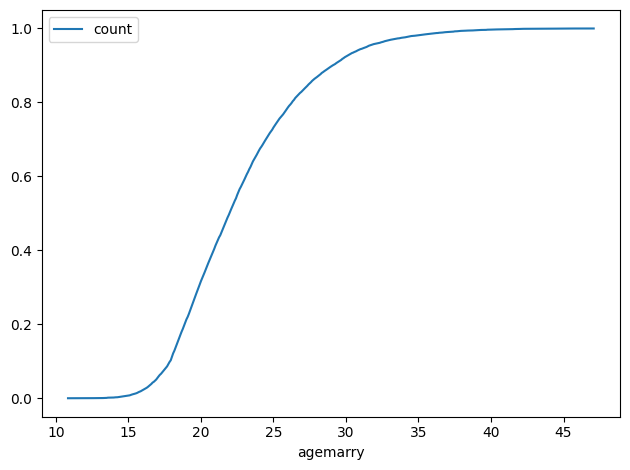

In [12]:
cdf = Cdf.from_seq(nsfg_female['agemarry'])
cdf.plot()
decorate()

In [13]:
nsfg_female['observed'] = nsfg_female['evrmarry']
nsfg_female.loc[evrmarry, 'duration'] = nsfg_female['agemarry']
nsfg_female.loc[~evrmarry, 'duration'] = nsfg_female['age']

In [14]:
values(nsfg_female['birth_index'])

birth_index
30       323
40      4014
50     10381
60     15638
70     17170
80     13793
90      7835
100     1029
Name: count, dtype: int64

In [15]:
def make_kmf_map(grouped):
    kmf_map = {}

    for cohort, group in grouped:
        kmf = KaplanMeierFitter()
        kmf.fit(group['duration'], group['observed'])
        series = (1 - kmf.survival_function_['KM_estimate']) * 100
        series.name = cohort
        kmf_map[cohort] = series
        
    return kmf_map

In [16]:
grouped = nsfg_female.dropna(subset='duration').groupby('birth_index')
nsfg_map = make_kmf_map(grouped)

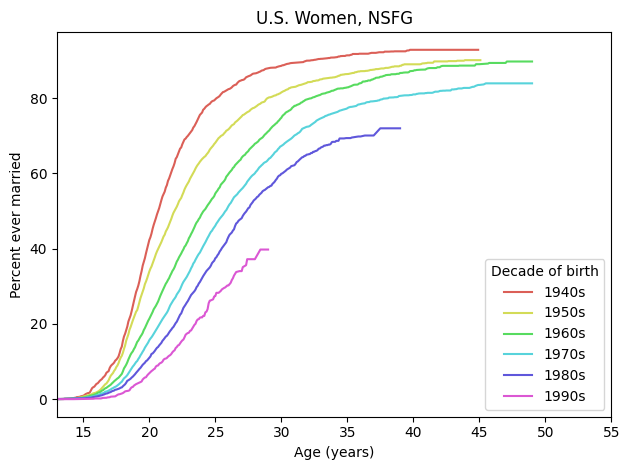

In [17]:
cohorts = range(40, 100, 10)
plot_kmf_map(nsfg_map, cohorts, title='U.S. Women, NSFG')

## NSFG time between marriages

In [18]:
values(nsfg_female['cycle'])

cycle
3      7969
4      8450
5     10847
6      7643
7     12279
8      5601
9      5699
10     5554
11     6141
Name: count, dtype: int64

In the last two cycles, the `mardat` variables are in years rather than century-months.

In [19]:
subset = nsfg_female.query('cycle <= 9')

In [20]:
subset['mardat01'].notna().sum()

16635

In [21]:
subset['mardat02'].notna().sum()

902

In [22]:
subset['mardat03'].notna().sum()

91

In [23]:
subset['mardat04'].notna().sum()

19

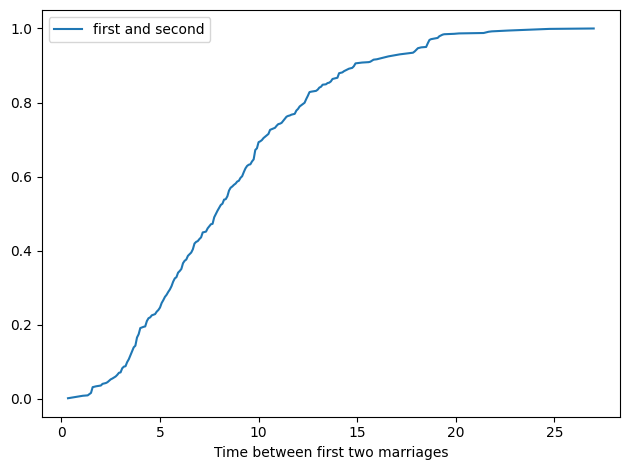

In [24]:
time_between_two = (subset['mardat02'] - subset['mardat01']) / 12
pmf_two = Pmf.from_seq(time_between_two, name='first and second')
pmf_two.make_cdf().plot()
decorate(xlabel='Time between first two marriages')

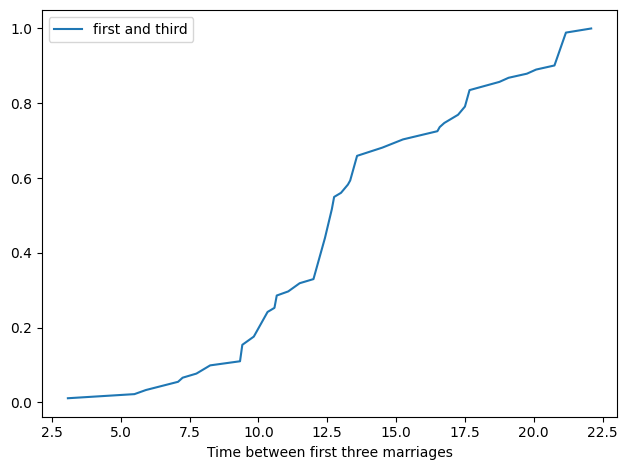

In [25]:
time_between_three = (subset['mardat03'] - subset['mardat01']) / 12
pmf_three = Pmf.from_seq(time_between_three, name='first and third')
pmf_three.make_cdf().plot()
decorate(xlabel='Time between first three marriages')

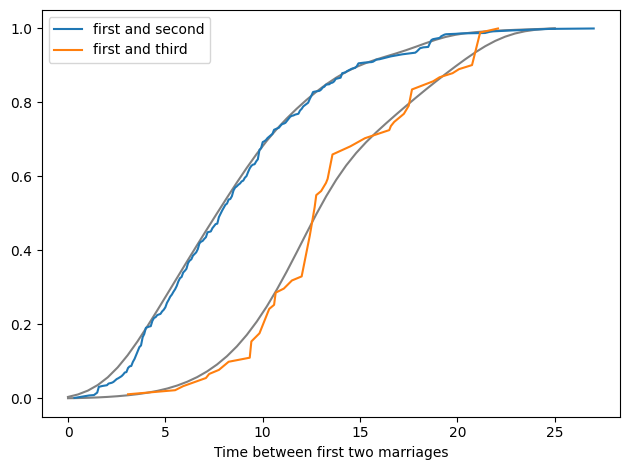

In [26]:
from scipy.stats import gaussian_kde

kde_two = gaussian_kde(time_between_two.dropna())
kde_three = gaussian_kde(time_between_three.dropna())

qs = np.linspace(0, 25)
ps = kde_two(qs)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.make_cdf().plot(color='gray')

ps = kde_three(qs)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.make_cdf().plot(color='gray')

pmf_two.make_cdf().plot()
pmf_three.make_cdf().plot()
decorate(xlabel='Time between first two marriages')

In [27]:
np.percentile(time_between_two.dropna(), [50])

array([7.91666667])

In [28]:
np.percentile(time_between_three.dropna(), [50])

array([12.66666667])

Load the IPUMS data.

In [29]:
unweighted = pd.read_csv('usa_00002.csv.gz')
unweighted.shape

(4421014, 17)

In [30]:
unweighted.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,SEX,AGE,BIRTHQTR,MARST,BIRTHYR,MARRNO,YRMARR
0,2008,200801,11,451,741.48,2008000000111,90301,1,1,731.46,1,35,4,1,1973,1,1999
1,2008,200801,11,451,741.48,2008000000111,90301,1,2,601.20,2,32,1,1,1976,1,1999
2,2008,200801,11,451,741.48,2008000000111,90301,1,3,851.70,1,3,4,6,2005,0,0
3,2008,200801,11,451,741.48,2008000000111,90301,1,4,861.72,1,0,4,6,2008,0,0
4,2008,200801,21,1441,270.54,2008000000211,180001,1,1,260.52,1,50,3,4,1958,1,1986


In [31]:
np.random.seed(random_seed)
df = resample_rows_weighted(unweighted, 'PERWT').reset_index(drop=True)

In [32]:
df.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,SEX,AGE,BIRTHQTR,MARST,BIRTHYR,MARRNO,YRMARR
0,2010,201001,344770,1242943,609.39,2010003447701,210412,1,3,689.31,1,18,2,6,1992,0,0
1,2018,201801,668078,2018000899530,329.67,2018006680781,10026,1,1,319.68,2,65,3,1,1953,1,1972
2,2011,201101,1137184,1046490,727.81,2011011371841,130247,1,3,757.72,1,13,3,6,1998,0,0
3,2015,201501,870801,1118401,1976.04,2015008708011,411336,1,2,1976.04,1,59,2,1,1956,1,1989
4,2008,200801,276573,308084,601.20,2008002765731,370212,1,2,480.96,2,56,2,1,1952,2,1990


In [33]:
values(df['YEAR'])

YEAR
2008    299410
2009    302983
2010    306569
2011    308061
2012    311020
2013    311509
2014    317721
2015    317237
2016    321294
2017    321932
2018    322854
2019    323509
2021    326095
2022    330820
Name: count, dtype: int64

In [34]:
values(df['SEX'])

SEX
1    2179525
2    2241489
Name: count, dtype: int64

In [35]:
df['AGE'].isna().sum()

0

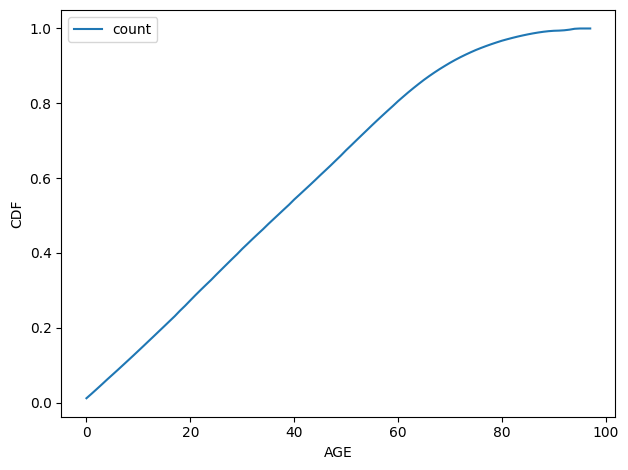

In [36]:

cdf_age = Cdf.from_seq(df['AGE'])
cdf_age.plot()
decorate(ylabel='CDF')

In [37]:
df['BIRTHYR'].isna().sum()

0

In [38]:
df['BIRTHYR'].describe()

count    4.421014e+06
mean     1.976567e+03
std      2.323732e+01
min      1.913000e+03
25%      1.959000e+03
50%      1.978000e+03
75%      1.996000e+03
max      2.022000e+03
Name: BIRTHYR, dtype: float64

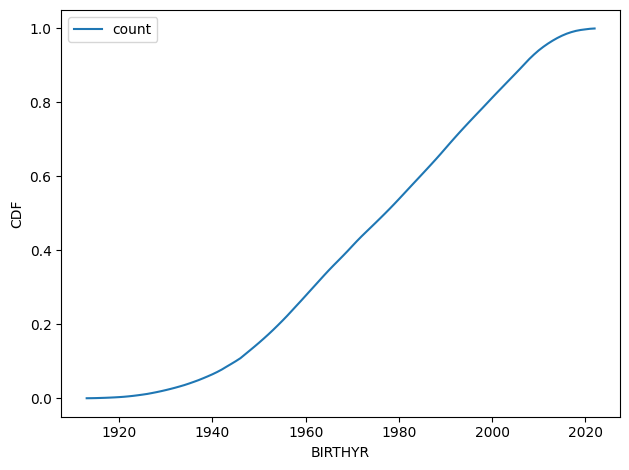

In [39]:
cdf_birthyr = Cdf.from_seq(df['BIRTHYR'])
cdf_birthyr.plot()
decorate(ylabel='CDF')

In [40]:
values(df['MARRNO'])

MARRNO
0    2033496
1    1805405
2     457689
3     124424
Name: count, dtype: int64

In [41]:
values(df['MARST'])

MARST
1    1638788
2      78830
3      72179
4     388805
5     208916
6    2033496
Name: count, dtype: int64

In [42]:
married0 = df['MARRNO'] == 0
married0.mean()

0.45996144775836495

In [43]:
married1 = df['MARRNO'] == 1
married1.mean()

0.4083689850337502

In [44]:
married2 = df['MARRNO'] == 2
married2.mean()

0.1035257974754208

`married3` actually means three or more times

In [45]:
married3 = df['MARRNO'] == 3
married3.mean()

0.028143769732464092

In [46]:
df['cohort10'] = round_into_bins(df, 'BIRTHYR', 10) - 1900

In [47]:
millennial1 = df['BIRTHYR'].between(1981, 1988)
millennial1.sum()

480383

In [48]:
millennial2 = df['BIRTHYR'].between(1989, 1995)
millennial2.sum()

436541

In [49]:
genz1 = df['BIRTHYR'].between(1996, 2003)
genz1.sum()

467955

In [50]:
genz2 = df['BIRTHYR'].between(2004, 2012)
genz2.sum()

474873

In [51]:
df['gen'] = np.nan
df.loc[millennial1, 'gen'] = 1
df.loc[millennial2, 'gen'] = 2
df.loc[genz1, 'gen'] = 3
df.loc[genz2, 'gen'] = 4

In [52]:
values(df['gen'])

gen
1.0     480383
2.0     436541
3.0     467955
4.0     474873
NaN    2561262
Name: count, dtype: int64

In [53]:
df['agemarr'] = df['YRMARR'] - df['BIRTHYR']
df['duration'] = np.nan
df['observed'] = np.nan

In [54]:
df.loc[married0, 'duration'] = df.loc[married0, 'AGE']
df.loc[married0, 'observed'] = 0

In [55]:
df.loc[married1, 'duration'] = df.loc[married1, 'agemarr']
df.loc[married1, 'observed'] = 1

NOTE: This step is something to come back to. YRMARR is the year of the last marriage, so this calculation is not correct for people who have been married more than once.

In [56]:
agemarr_cdf = Cdf.from_seq(df['agemarr'])

In [57]:
df['filled'] = np.nan

np.random.seed(random_seed)
for cohort in range(10, 110, 10):
    donors = (df['cohort10'] == cohort) & (df['MARRNO'] == 1)
    agemarr = df.loc[donors, 'agemarr']
    low, high = np.percentile(agemarr, [10, 90])
    index = agemarr.between(low, high)

    missing = (df['cohort10'] == cohort) & (df['MARRNO'] > 1)
    n = missing.sum()
    sample = np.random.choice(agemarr[index], size=n, replace=True)
    print(cohort, n, sample.mean())
    df.loc[missing, 'filled'] = sample

10 1873 26.934329951948744
20 15025 24.089384359401
30 43900 23.231617312072892
40 110217 23.257945688959055
50 163049 24.64533361136836
60 139021 25.98482963005589
70 79702 26.109984692981357
80 26753 24.569281949687884
90 2544 22.29795597484277
100 29 18.17241379310345


In [58]:
df['filled'].describe()

count    582113.000000
mean         24.775408
std           4.673245
min          15.000000
25%          21.000000
50%          24.000000
75%          28.000000
max          45.000000
Name: filled, dtype: float64

In [59]:
# first approx: treat MARRNO > 1 as if we have age at first marriage
df.loc[married2, 'duration'] = df.loc[married2, 'agemarr']
df.loc[married2, 'observed'] = 1

In [60]:
# second approx: treat MARRNO > 1 as if unmarried
df.loc[married2, 'duration'] = df.loc[married2, 'AGE']
df.loc[married2, 'observed'] = 0

In [61]:
# fourth approx: treat MARRNO > 1 as missing data and infer
df.loc[married2, 'duration'] = np.minimum(df.loc[married2, 'filled'], 
                                          df.loc[married2, 'agemarr'])
df.loc[married2, 'observed'] = 1

In [62]:
df.loc[married3, 'duration'] = np.minimum(df.loc[married3, 'filled'], 
                                          df.loc[married3, 'agemarr'])
df.loc[married3, 'observed'] = 1

In [63]:
df['duration'].isna().sum()

0

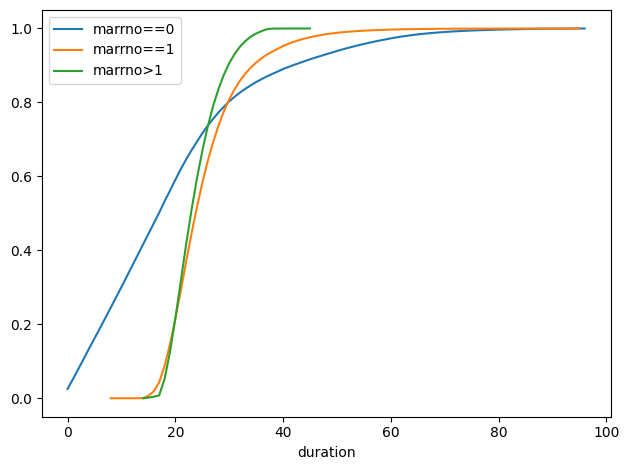

In [64]:
Cdf.from_seq(df.loc[married0, 'duration']).plot(label='marrno==0')
Cdf.from_seq(df.loc[married1, 'duration']).plot(label='marrno==1')
Cdf.from_seq(df.loc[married2, 'duration']).plot(label='marrno>1')
decorate()

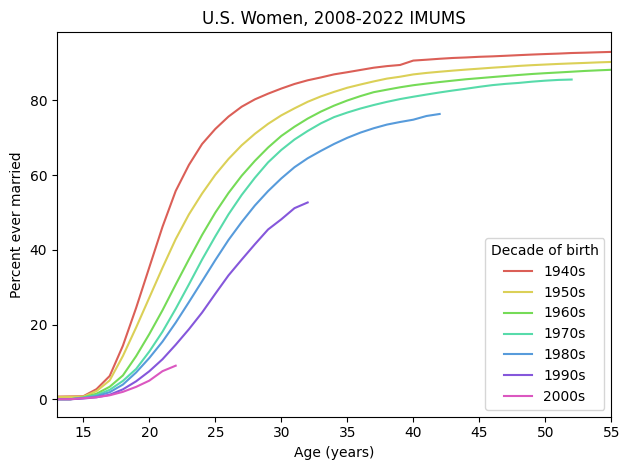

In [66]:
grouped = df.query('AGE<=65 and SEX==2').groupby('cohort10')
kmf_map = make_kmf_map(grouped)

cohorts = range(40, 110, 10)
plot_kmf_map(kmf_map, cohorts, title='U.S. Women, 2008-2022 IMUMS')

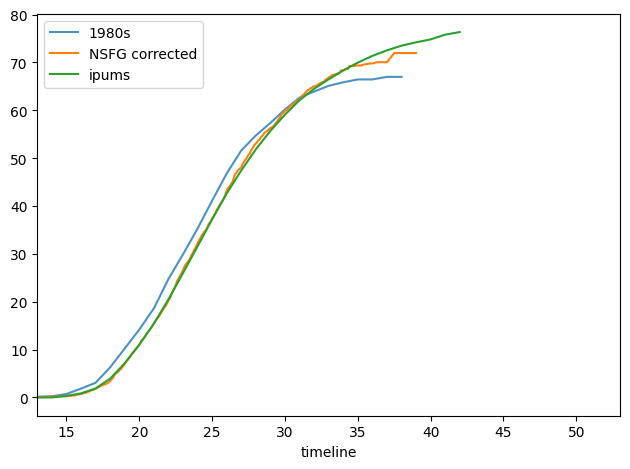

In [67]:
cohort = 80
sf_map_subset = {key: sf_map[key] for key in [cohort] if key in sf_map}
PlotSurvivalFunctions(sf_map_subset)

nsfg_map[cohort].plot(label='NSFG corrected')
kmf_map[cohort].plot(label='ipums')

decorate(xlim=[13, 53])

Now the men

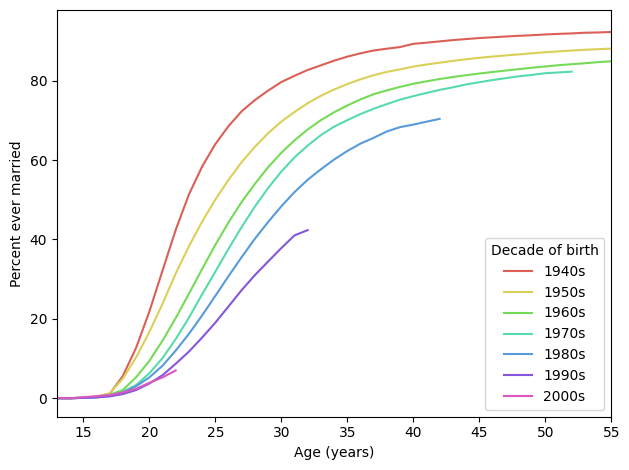

In [69]:
grouped = df.query('AGE<=65 and SEX==1').groupby('cohort10')
kmf_map = make_kmf_map(grouped)

cohorts = range(40, 110, 10)
plot_kmf_map(kmf_map, cohorts, title='')